Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores hiperparámetros: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
MAE: 3,102.20
R² : 0.7114


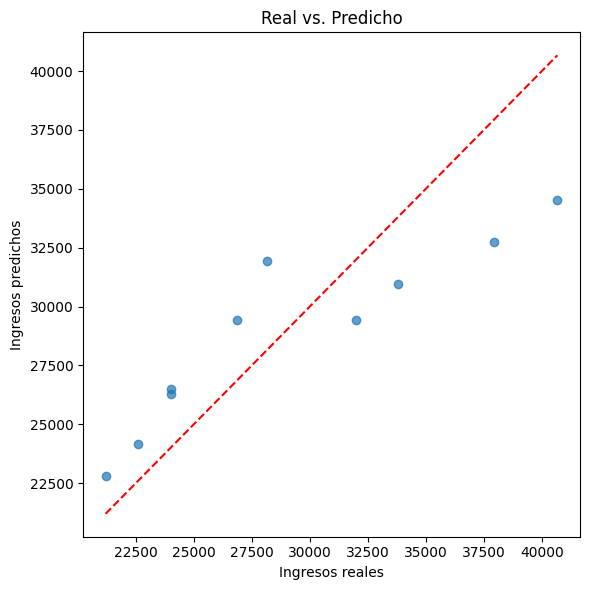

R²=0.7114 < 0.75; no se guardará modelo.


,year_month,actual_income,predicted_income
0,2021-05-01,24000.0,26481.78
1,2022-01-01,22600.0,24143.12
2,2022-08-01,37930.0,32722.94
3,2023-01-01,40670.0,34517.96
4,2023-02-01,26880.0,29412.16
5,2023-03-01,21200.0,22796.80
6,2023-04-01,32000.0,29424.02
7,2024-02-01,28140.0,31944.26
8,2024-05-01,24000.0,26279.92
9,2024-08-01,33810.0,30961.16


In [1]:
# modelo_prediccion_final_tuning.ipynb

# === Cell 1: Imports y configuración ===
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib

plt.rcParams['figure.figsize'] = (6,6)


# === Cell 2: Carga y merge de datos ===
BASE = Path(r"C:/Users/Perydox/Desktop/Proyecto_Grado - copia/data/Datos_final")
areas = pd.read_csv(BASE/"areas_final.csv", header=None, names=['area_id','area_name'])
pacientes = pd.read_csv(BASE/"pacientes_final.csv", header=None,
                        names=['patient_id','patient_name','age','gender','registration_date'])
tratamientos = pd.read_csv(BASE/"tratamientos_final.csv", header=None,
                           names=['treatment_id','treatment_name','area_id','price'])
atenciones = pd.read_csv(BASE/"atenciones_final.csv", header=None,
                         names=['attention_id','patient_id','treatment_id','attention_date','payment_type','status','extra'])
atenciones = atenciones.drop(columns=['extra'])

df = (
    atenciones
    .merge(pacientes, on='patient_id', how='left')
    .merge(tratamientos, on='treatment_id', how='left')
    .merge(areas, on='area_id', how='left')
)
df['attention_date'] = pd.to_datetime(df['attention_date'])


# === Cell 3: Ingeniería de variables mensuales ===
df['year_month'] = df['attention_date'].dt.to_period('M').dt.to_timestamp()

monthly_income  = df.groupby('year_month')['price'].sum().rename('gross_income')
monthly_count   = df.groupby('year_month').size().rename('n_attentions')
unique_patients = df.groupby('year_month')['patient_id'].nunique().rename('n_unique_patients')
avg_age         = df.groupby('year_month')['age'].mean().rename('avg_age')

data = pd.concat([monthly_income, monthly_count, unique_patients, avg_age], axis=1).dropna().reset_index()


# === Cell 4: Definir X, y y split aleatorio ===
X = data[['n_attentions','n_unique_patients','avg_age']]
y = data['gross_income']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)


# === Cell 5: Búsqueda de hiperparámetros con GridSearchCV ===
param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

rf = grid.best_estimator_
print("Mejores hiperparámetros:", grid.best_params_)


# === Cell 6: Evaluación del modelo optimizado ===
y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.2f}")
print(f"R² : {r2:.4f}")

plt.scatter(y_test, y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Ingresos reales")
plt.ylabel("Ingresos predichos")
plt.title("Real vs. Predicho")
plt.tight_layout()
plt.show()


# === Cell 7: Guardado condicional ===
if r2 >= 0.75:
    MODELS_DIR = Path("models")
    MODELS_DIR.mkdir(exist_ok=True)
    joblib.dump(rf, MODELS_DIR/"rf_income_model_tuned.joblib")
    print("Modelo guardado (R² >= 0.75).")
else:
    print(f"R²={r2:.4f} < 0.75; no se guardará modelo.")

    # === Cell 7: Mostrar predicción de ingresos mensuales brutos ===
import pandas as pd

# Reconstruir el DataFrame original con 'year_month'
# Suponiendo que en Cell 3 hiciste:
# data = pd.concat([...], axis=1).dropna().reset_index()
# y por tanto data['year_month'] existe

# Vuelves a recrear data tal cual, o si la tienes en memoria:
# data = ...

# Divide data en train/test para que coincidan índices
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

# Entrena de nuevo sobre data_train
# ... tu rf.fit(X_train, y_train)

# Ya tienes y_pred y data_test['gross_income'] y data_test['year_month']
pred_df = pd.DataFrame({
    'year_month':    data_test['year_month'].values,
    'actual_income': data_test['gross_income'].values,
    'predicted_income': y_pred
})

pred_df = pred_df.sort_values('year_month').reset_index(drop=True)

display(pred_df)



Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores hiperparámetros: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
MAE: 3,102.20
R² : 0.7114


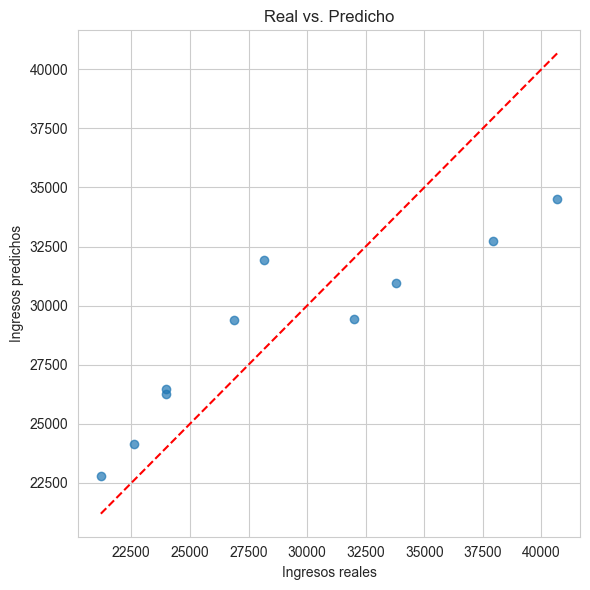

Modelo guardado (R² >= 0.70).


,year_month,actual_income,predicted_income
0,2021-05-01,24000.0,26481.78
1,2022-01-01,22600.0,24143.12
2,2022-08-01,37930.0,32722.94
3,2023-01-01,40670.0,34517.96
4,2023-02-01,26880.0,29412.16
5,2023-03-01,21200.0,22796.80
6,2023-04-01,32000.0,29424.02
7,2024-02-01,28140.0,31944.26
8,2024-05-01,24000.0,26279.92
9,2024-08-01,33810.0,30961.16


Test RMSE: 3,418.85
Test R²  : 0.7114



,year_month,predicted_income
0,2025-01-01,27508.66
1,2025-02-01,29040.54
2,2025-03-01,31126.56
3,2025-04-01,29312.18
4,2025-05-01,30366.10
5,2025-06-01,29108.46
6,2025-07-01,25783.56
7,2025-08-01,31348.98
8,2025-09-01,28401.08
9,2025-10-01,26998.00


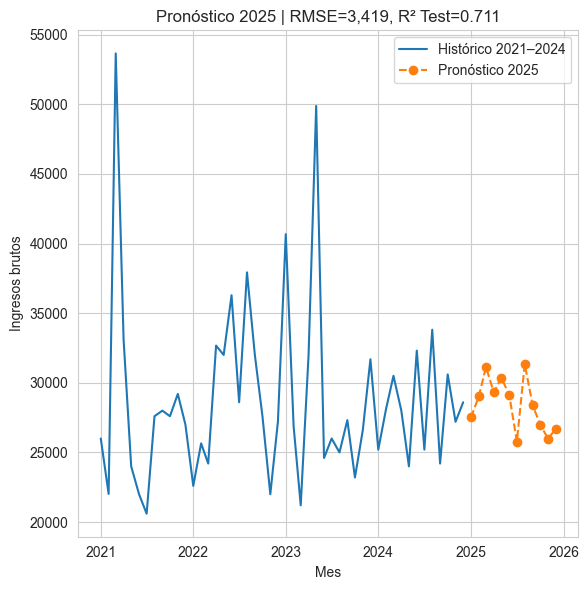

In [54]:
# === Cell 1: Imports y configuración ===
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import joblib
from IPython.display import display

plt.rcParams['figure.figsize'] = (6,6)


# === Cell 2: Carga y merge de datos ===
BASE = Path(r"C:/Users/Perydox/Desktop/Proyecto_Grado - copia/data/Datos_final")
areas = pd.read_csv(BASE/"areas_final.csv", header=None, names=['area_id','area_name'])
pacientes = pd.read_csv(BASE/"pacientes_final.csv", header=None,
                        names=['patient_id','patient_name','age','gender','registration_date'])
tratamientos = pd.read_csv(BASE/"tratamientos_final.csv", header=None,
                           names=['treatment_id','treatment_name','area_id','price'])
atenciones = pd.read_csv(BASE/"atenciones_final.csv", header=None,
                         names=['attention_id','patient_id','treatment_id','attention_date','payment_type','status','extra'])
atenciones = atenciones.drop(columns=['extra'])

df = (
    atenciones
    .merge(pacientes, on='patient_id', how='left')
    .merge(tratamientos, on='treatment_id', how='left')
    .merge(areas, on='area_id', how='left')
)
df['attention_date'] = pd.to_datetime(df['attention_date'])


# === Cell 3: Ingeniería de variables mensuales ===
df['year_month'] = df['attention_date'].dt.to_period('M').dt.to_timestamp()

monthly_income  = df.groupby('year_month')['price'].sum().rename('gross_income')
monthly_count   = df.groupby('year_month').size().rename('n_attentions')
unique_patients = df.groupby('year_month')['patient_id'].nunique().rename('n_unique_patients')
avg_age         = df.groupby('year_month')['age'].mean().rename('avg_age')

data = pd.concat([monthly_income, monthly_count, unique_patients, avg_age], axis=1).dropna().reset_index()


# === Cell 4: Definir X, y y split aleatorio ===
X = data[['n_attentions','n_unique_patients','avg_age']]
y = data['gross_income']
dates = data['year_month']

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, test_size=0.2, shuffle=True, random_state=42
)


# === Cell 5: Búsqueda de hiperparámetros con GridSearchCV ===
param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

rf = grid.best_estimator_
print("Mejores hiperparámetros:", grid.best_params_)


# === Cell 6: Evaluación del modelo optimizado ===
y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.2f}")
print(f"R² : {r2:.4f}")

plt.scatter(y_test, y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Ingresos reales")
plt.ylabel("Ingresos predichos")
plt.title("Real vs. Predicho")
plt.tight_layout()
plt.show()


# === Cell 7: Guardado condicional ===
if r2 >= 0.70:
    MODELS_DIR = Path("models")
    MODELS_DIR.mkdir(exist_ok=True)
    joblib.dump(rf, MODELS_DIR/"modelo_final_2025.joblib")
    print("Modelo guardado (R² >= 0.70).")
else:
    print(f"R²={r2:.4f} < 0.70; no se guardará modelo.")


# === Cell 8: Tabla de predicción en Test ===
pred_df = pd.DataFrame({
    'year_month':      dates_test.values,
    'actual_income':   y_test.values,
    'predicted_income': y_pred
})
pred_df = pred_df.sort_values('year_month').reset_index(drop=True)
display(pred_df)


# === Cell 9: Métricas en Test + Proyección 2025 ===
# 1. Cálculo de RMSE y R² en test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:,.2f}")
print(f"Test R²  : {r2_test:.4f}\n")

# 2. Proyección de ingresos mensuales 2025
future_idx = pd.date_range('2025-01-01','2025-12-01',freq='MS')
future = pd.DataFrame({'year_month': future_idx})
future['mes'] = future['year_month'].dt.month

# Mapear promedios históricos de variables
hist_means = data.groupby(data['year_month'].dt.month)[['n_attentions','n_unique_patients','avg_age']].mean()
for var in ['n_attentions','n_unique_patients','avg_age']:
    future[var] = future['mes'].map(hist_means[var])

# Predecir para 2025
X_future = future[['n_attentions','n_unique_patients','avg_age']]
future['predicted_income'] = rf.predict(X_future)

# 3. Mostrar resultados
projection_df = future[['year_month','predicted_income']].reset_index(drop=True)
display(projection_df)

# 4. Gráfica histórica vs. pronóstico
plt.plot(data['year_month'], data['gross_income'], label='Histórico 2021–2024')
plt.plot(future['year_month'], future['predicted_income'], '--o', label='Pronóstico 2025')
plt.xlabel('Mes')
plt.ylabel('Ingresos brutos')
plt.title(f"Pronóstico 2025 | RMSE={rmse:,.0f}, R² Test={r2_test:.3f}")
plt.legend()
plt.tight_layout()
plt.show()
